In [23]:
import zipfile
import os
import glob

zip_path = 'data/raw/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone.zip'

extract_path = 'data/extract'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

data_dir = 'data/extract/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# List class names (folder names)
classes = sorted(os.listdir(data_dir))
print("Detected classes:", classes)


Detected classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5129630719081649100
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2357670708
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12306689591474748110
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
!nvidia-smi


Wed May 28 00:48:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              3W /   50W |    2319MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
!where cudart64_110.dll

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin\cudart64_110.dll


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


In [29]:
train_dir = 'data/kidney_split/train'
val_dir = 'data/kidney_split/val'


In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [31]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Optional: View class indices
print("Class Indices:", train_generator.class_indices)


Found 9955 images belonging to 4 classes.
Found 2491 images belonging to 4 classes.
Class Indices: {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


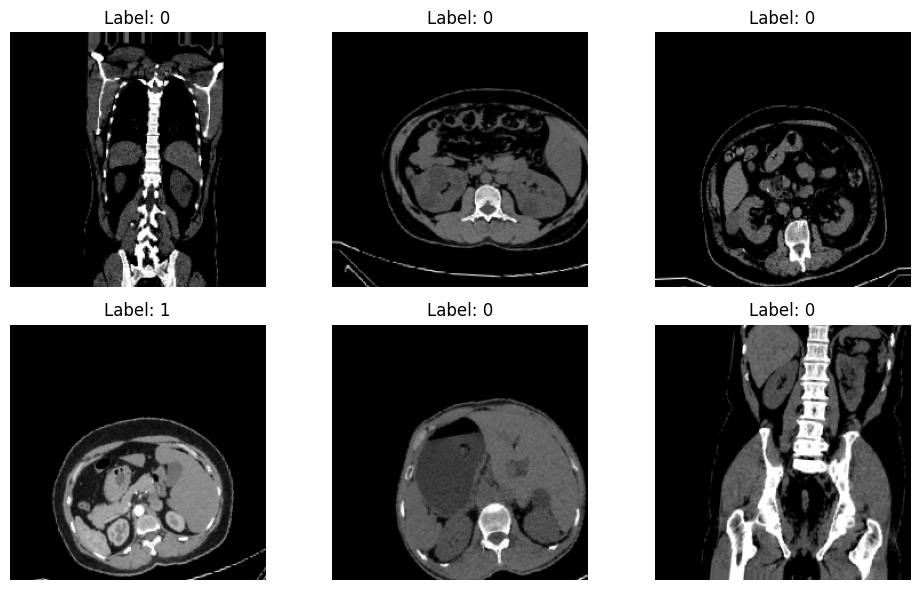

In [32]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {np.argmax(y_batch[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [34]:
EPOCHS = 100
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Epoch 1/100
312/312 [==============================] - 346s 1s/step - loss: 1.3246 - accuracy: 0.3840 - val_loss: 1.2180 - val_accuracy: 0.4400
Epoch 2/100
312/312 [==============================] - 193s 618ms/step - loss: 1.2098 - accuracy: 0.4864 - val_loss: 1.1135 - val_accuracy: 0.6150
Epoch 3/100
312/312 [==============================] - 190s 608ms/step - loss: 1.1138 - accuracy: 0.5665 - val_loss: 0.9936 - val_accuracy: 0.6287
Epoch 4/100
312/312 [==============================] - 192s 614ms/step - loss: 1.0105 - accuracy: 0.6180 - val_loss: 0.8908 - val_accuracy: 0.6692
Epoch 5/100
312/312 [==============================] - 280s 897ms/step - loss: 0.9286 - accuracy: 0.6485 - val_loss: 0.8165 - val_accuracy: 0.7009
Epoch 6/100
312/312 [==============================] - 199s 636ms/step - loss: 0.8576 - accuracy: 0.6785 - val_loss: 0.7473 - val_accuracy: 0.7162
Epoch 7/100
312/312 [==============================] - 191s 613ms/step - loss: 0.8147 - accuracy: 0.6958 - val_loss: 0.69

In [36]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
model.save("vgg16_model.keras")

1/1 [==============================] - 0s 268ms/step


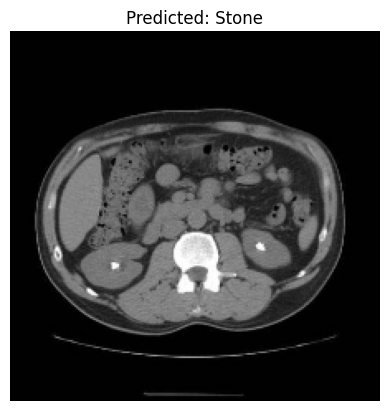

In [37]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Load Trained Model ---
model = load_model("vgg16_finetuned_model.keras")

# --- Define Preprocessing Function (Same as Training) ---
def preprocess_img(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

# --- Load and Preprocess Image ---
test_image_path = "kidney_stone1.jpeg"  # Change this
img = preprocess_img(test_image_path)
img_batch = np.expand_dims(img, axis=0)  # Add batch dimension

# --- Predict ---
pred = model.predict(img_batch)
pred_class_idx = np.argmax(pred, axis=1)[0]
pred_class_label = classes[pred_class_idx]  # classes from earlier step

# --- Show Result ---
plt.imshow(img)
plt.title(f"Predicted: {pred_class_label}")
plt.axis("off")
plt.show()


In [38]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


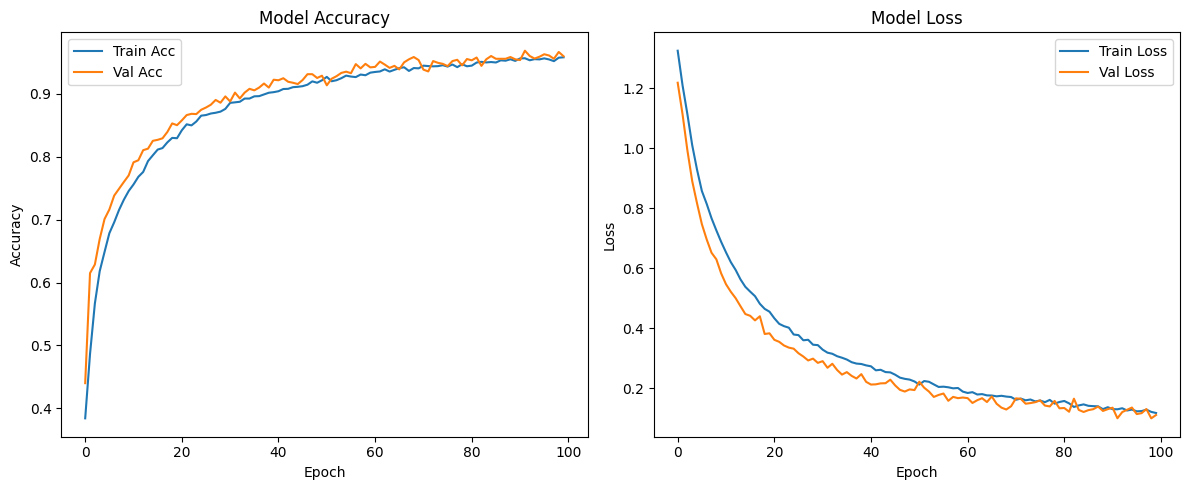

In [39]:
# Call this after training is done
plot_training_history(history)


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate predictions
y_true = []
y_pred = []

# Iterate over validation data
for i in range(val_steps):
    x_batch, y_batch = next(val_gen)
    
    # Model predictions
    y_pred_batch = model.predict(x_batch)
    
    # Get class indices
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(y_pred_batch, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Classification report
print("\nClassification Report:")
target_names = [f'Class {i}' for i in range(NUM_CLASSES)]  # or your actual class labels
print(classification_report(y_true, y_pred, target_names=target_names))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# 4. Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))


NameError: name 'val_steps' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
y_true = []
y_probs = []

for i in range(val_steps):
    x_batch, y_batch = next(val_gen)
    y_prob_batch = model.predict(x_batch)
    
    y_true.extend(y_batch)
    y_probs.extend(y_prob_batch)

# Convert to numpy arrays
y_true = np.array(y_true)
y_probs = np.array(y_probs)


1/1 [==============================] - 0s 40ms/step


C:\Users\gaura\AppData\Local\Temp\ipykernel_18216\143691095.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', NUM_CLASSES)


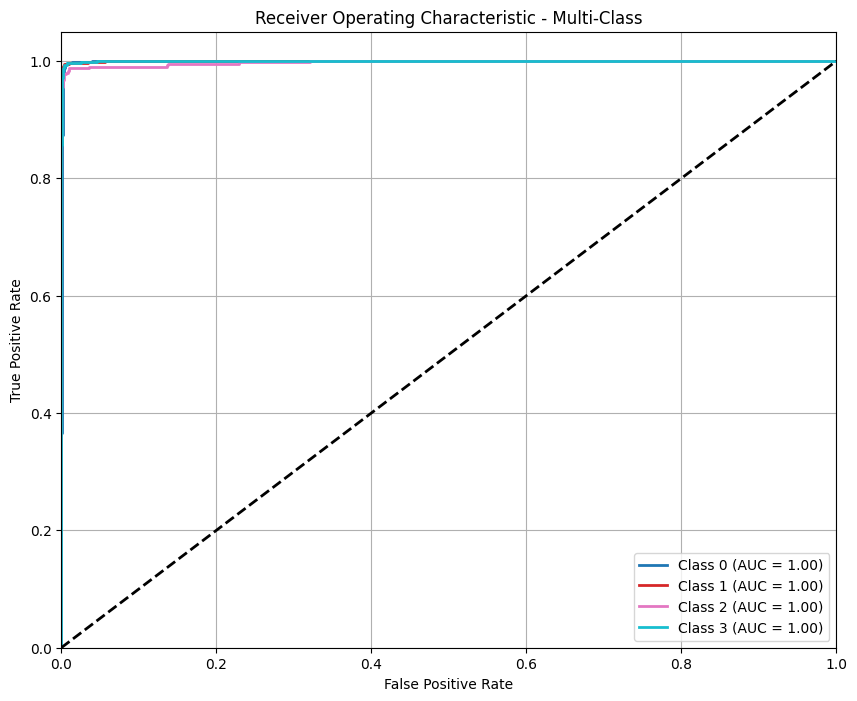

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', NUM_CLASSES)

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
